In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

from impedance import preprocessing
from impedance.validation import linKK
from impedance.visualization import plot_nyquist, plot_residuals

In [2]:
FOLDER_NAMES = ["autolab/03112020_human_blood"]

DATA_PATH = "../../data/"
FILENAME_STRING = "blood"
FILENAME_RULE = "starts"
LOWER_CUTOFF_FREQUENCY = 630.96

FREQUENCY_HEADER = "Frequency (Hz)"
IMPEDANCE_HEADER_ABS = "magnitude"
IMPEDANCE_HEADER_PHASE = "phase"
IMPEDANCE_HEADER_REAL_COMPONENT = "Z' (Ω)"
IMPEDANCE_HEADER_IMAGINARY_COMPONENT = "-Z'' (Ω)"

In [3]:
# Some helper functions


def get_file_name(file):
    heat, tail = os.path.split(file)
    return tail


def get_files(path, filename_string, filename_rule):
    """Return a list of files that contain given string from a given directory.
    Filename rule determines whether the string is at the beginning or the end of the file.
            """
    files = []
    with os.scandir(path) as all_files:
        for file in all_files:
            if filename_rule == 'starts':
                if file.name.startswith(filename_string):
                    files.append(file)

            if filename_rule == 'ends':
                if file.name.endswith(filename_string):
                    files.append(file)
    return files



def read_autolab_file(file):
    """Return a dataframe with the data from the file"""
    delimiter = "\t"
    df = pd.read_csv(file, delimiter=delimiter)
    # Add file name to data frame
    df["file_name"] = get_file_name(file)
    return df



def load_from_files(files, header_rows=0):
    """Load data from a list of files and returns list of dataframes
            """
    data_frames = [read_autolab_file(file) for file in files]
    return data_frames


def load_df(files):
    return pd.concat(load_from_files(files))


def get_f_z_list(df):
    """Formats the data from the dataframe for the validate_kk(df) function
        """

    array = df.loc[:, [FREQUENCY_HEADER, IMPEDANCE_HEADER_REAL_COMPONENT, IMPEDANCE_HEADER_IMAGINARY_COMPONENT]].to_numpy()
    f = array[:, 0]
    Z = array[:, 1] - 1j*array[:, 2]
    return f, Z


def validate_kk(df):
    """This function is copied from the example from the documentation page
        """
    f, Z = get_f_z_list(df)
    # keep only the impedance data in the first quadrant
    f, Z = preprocessing.ignoreBelowX(f, Z)
    print(f"Low frequency cutoff = {f[-1]}")
    M, mu, Z_linKK, res_real, res_imag = linKK(f, Z, c=.5, max_M=2, fit_type='complex', add_cap=True)

    print('\nCompleted Lin-KK Fit\nM = {:d}\nmu = {:.2f}'.format(M, mu))

    M = 26
    mu = 0.31

    fig = plt.figure(figsize=(7, 6))
    gs = fig.add_gridspec(3, 1)
    ax1 = fig.add_subplot(gs[:2,:])
    ax2 = fig.add_subplot(gs[2,:])

    # plot original data
    plot_nyquist(ax1, Z, fmt='s')

    # plot measurement model
    plot_nyquist(ax1, Z_linKK, fmt='-', scale=1e3, units='\Omega')

    ax1.legend(['Data', 'Lin-KK model'], loc=2, fontsize=12)

    # Plot residuals
    plot_residuals(ax2, f, res_real, res_imag, y_limits=(-2,2))

    plt.tight_layout()
    plt.show()



Low frequency cutoff = 316.23

Completed Lin-KK Fit
M = 3
mu = 1.00


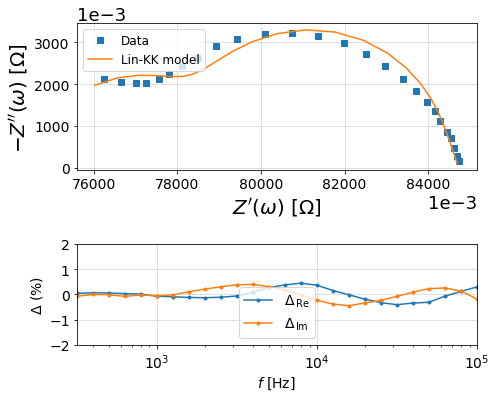

In [4]:
files = [file for FOLDER_NAME in FOLDER_NAMES
         for file in get_files(os.path.join(DATA_PATH, FOLDER_NAME), FILENAME_STRING, FILENAME_RULE)]
df = load_df(files)
validate_kk(df)